# Applied Data Science Capstone

## Best Spots to Open Chinese Restaurant in Toronto

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 10px">

<font size = 3>

1. <a href="#item1">Data Preparation</a>

2. <a href="#item2">Area Clustering</a>

3. <a href="#item3">Exploring Neighbourhoods</a>

4. <a href="#item4">Finding the Best Spot</a>

  
</font>
</div>

In [1]:
# installing geocoder
!pip install geocoder -q

# Import required libraries
import pandas as pd, numpy as np, geocoder, folium, matplotlib.cm as cm, matplotlib.colors as colors, matplotlib.pyplot as plt, requests 

# Import k-means & MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


<a id="item1"> </a>
### 1. Data Preparation
This stage consists of loading the csv file from the web, loading its contents to Pandas DataFrames, then cleaning and arranging this DataFrame to be ready for visualization and further analysis.

Three DataFrames are constructed on this stage:
* df_neig: That contains areas in Toronto, each area with its latitude and longitude 
* df_demo: which contains population of different ethnicities per area
* df_demo_sorted: which is a sorted version of df_demo by top ethnicities

Areas are then visualized on a map, based on each area's latitude and longitude

In [2]:
tor_eth = "https://bit.ly/3d7QPqX"
df_raw = pd.read_csv(tor_eth, thousands=',', encoding = "cp1252" )
df_raw.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,...,37,7,137,64,60,94,100,97,27,31
1,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [3]:
# filtering the required column
df_neig = df_raw[df_raw.Characteristic == "Neighbourhood Number"]

df_neig = df_neig.drop(['Category','Topic','Data Source','Characteristic','City of Toronto'], axis = 1)
df_neig = df_neig.T
df_neig = df_neig.reset_index()
df_neig = df_neig.iloc[:, ::-1]
df_neig.columns = ['Neighbourhood Number', 'Area']
df_neig.head()

,Neighbourhood Number,Area
0,129,Agincourt North
1,128,Agincourt South-Malvern West
2,20,Alderwood
3,95,Annex
4,42,Banbury-Don Mills


In [4]:
# cleaning and preparing demographics dataframe
df_demo = df_raw.apply(lambda x: x.str.replace(',',''))

#filter topic column
df_demo = df_demo[df_demo.Topic =='Ethnic origin population']

#create new column Depth
df_demo['Depth'] = df_demo['Characteristic']

# calculating the depth of each ethnicity counting the number of leading spaces
for i, r in df_demo.iterrows():
    r['Depth'] = len(r['Depth']) - len(r['Depth'].lstrip())

# finding depth level of each ethnic to find deepest levels
df_demo['newLevel'] = np.where(df_demo['Depth'].shift(+1) > df_demo['Depth'],"new","")

# reverse data frame
df_demo = df_demo.iloc[::-1]


df_demo.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park,Depth,newLevel
1624,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Pacific Islands origins; n.i.e.,220,0,0,0,10,0,...,0,10,0,0,10,0,0,0,6,
1623,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Samoan,75,0,0,0,0,0,...,10,0,0,0,0,0,0,0,6,
1622,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Polynesian; n.o.s.,65,0,0,0,0,0,...,0,0,0,0,0,10,0,0,6,
1621,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Maori,145,0,0,0,10,10,...,0,0,0,0,0,0,0,0,6,
1620,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Hawaiian,130,0,0,0,0,0,...,0,0,0,0,0,10,0,0,6,


In [5]:
# Keep column will be used as keep row or remove it

df_demo['Keep'] = 0
tmp =""

for i, r in df_demo.iterrows():
 # first row is the deepest level
    if tmp =="":
        df_demo.loc[i, 'Keep'] = 1
        tmp = r['Depth']
        
    else:
        if tmp == r['Depth']:
            df_demo.loc[i, 'Keep'] = 1
        
        # reset tmp variable for new level
        elif r['newLevel'] == 'new':
            
            tmp =''

# Reverse the dataframe
df_demo = df_demo.iloc[::-1]

# keep required rows ['Keep']
df_demo = df_demo[df_demo.Keep == 1]

# Drop unused columns
df_demo = df_demo.drop(['Depth','newLevel','Keep'], 1)

df_demo.head()


,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1348,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,First Nations (North American Indian),27610,25,90,200,345,175,...,60,110,470,355,235,275,90,130,200,85
1349,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Inuit,515,0,0,15,20,10,...,0,0,25,0,0,10,0,0,0,0
1350,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Métis,8465,10,25,100,115,60,...,40,35,110,80,60,80,45,75,40,10
1352,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Acadian,2315,20,0,10,60,0,...,0,0,10,45,20,30,10,0,10,0
1353,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,American,27470,40,70,100,705,325,...,155,145,140,275,95,275,320,280,175,100


In [6]:
# dropping unused cloumns
df_demo = df_demo.drop(['Category','Topic','Data Source','City of Toronto'], axis = 1)
df_demo = df_demo.rename(columns={'Characteristic':''})

# Transpose the df to make areas as column
df_demo = df_demo.T
df_demo.columns = df_demo.iloc[0]
df_demo = df_demo.iloc[1:]

df_demo = df_demo.drop(df_demo.columns[[0]], axis = 1)

# reset index and format df
df_demo = df_demo.reset_index()
df_demo.rename(columns={'index':'Area'}, inplace=True)
df_demo.head()

,Area,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,Agincourt North,0,10,20,40,1295,0,10,0,0,...,0,320,20,135,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,25,0,70,1125,0,0,0,0,...,0,180,10,55,0,0,0,0,0,0
2,Alderwood,15,100,10,100,2245,0,15,0,0,...,110,45,0,0,0,0,0,0,0,0
3,Annex,20,115,60,705,4655,0,10,10,0,...,0,145,15,25,0,0,10,0,0,10
4,Banbury-Don Mills,10,60,0,325,3035,0,0,10,0,...,0,115,0,45,0,0,10,0,0,0


In [7]:
# function to return coordiantes (lat, long) for a given area, while loop to keep looping until result is returned 
def coord_tor (area_coord):  
    fcoord = None
    while (fcoord is None):
        g = geocoder.arcgis ('{}, Toronto, ON'. format (area_coord))
        fcoord =  g.latlng
        return fcoord[0], fcoord[1]


In [8]:
# loop through each area in df_neig to return lat and lng values in 2 columns in new list

area_with_coord=[]

for area in df_neig['Area']:
    lat, lng = coord_tor(area)
    area_with_coord.append([area, lat, lng])

#convert list to DF
df_neig_coord = pd.DataFrame (area_with_coord)
df_neig_coord.columns = ['Area','Latitude', 'Longitude']

# merge df_neig with df_neig_coord on 'Area'

df_neig = pd.merge (df_neig, df_neig_coord, on='Area')
df_neig.head()

,Neighbourhood Number,Area,Latitude,Longitude
0,129,Agincourt North,43.80930,-79.26707
1,128,Agincourt South-Malvern West,43.78736,-79.26935
2,20,Alderwood,43.60496,-79.54116
3,95,Annex,43.66936,-79.40280
4,42,Banbury-Don Mills,43.74041,-79.34852


In [11]:
# create map of Toronto using latitude and longitude values
map_tor = folium.Map(location=[coord_tor("")[0], coord_tor("")[1]], zoom_start=11)

# add markers to map
for lat, lng, neig_num, Area in zip(df_neig['Latitude'], df_neig['Longitude'], df_neig['Neighbourhood Number'], df_neig['Area']):
    label = '{} - {}'.format(neig_num, Area)
    label = folium.Popup(label, parse_html=True)

    #500m circle
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5).add_to(map_tor) 
    


map_tor

In [12]:
# Function to return most common ethnicities:

def most_common(row, top_filter):
    row_cat = row.iloc[1:].astype(float)
    row_cat_sorted = row_cat.sort_values(ascending = False)
    return row_cat_sorted.index.values[0:top_filter] #top filter defined next

In [13]:
# back to df_demo (demographics disttribution per area) dataframe
# as there are 251 ethnicities in the data frame, we will filter top 3 ethnicities per area

top_filter = 3 # top 3 ethnicitiies per area
indicators = ['st','nd','rd']
columns = ['Area']

# loop to create columns headers 1st Most Common Origin, etc.. Except when i=3 out of indicators list
for i in np.arange(top_filter):
    try:
        columns.append('{}{} Most Common Origin'.format(i+1, indicators[i]))
    #in case more ethniciities needed
    except:
        columns.append('{}th Most Common Origin'.format(i+1))

#Construct sorted dataframe
df_demo_sorted = pd.DataFrame(columns = columns)
df_demo_sorted['Area'] = df_demo['Area']

# loop through rows
for i in np.arange(df_demo.shape[0]):
    df_demo_sorted.iloc[i, 1:] = most_common(df_demo.iloc[i, :], top_filter)

df_demo_sorted.head()


,Area,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
0,Agincourt North,Chinese,Sri Lankan,East Indian
1,Agincourt South-Malvern West,Chinese,East Indian,Filipino
2,Alderwood,English,Canadian,Irish
3,Annex,English,Irish,Scottish
4,Banbury-Don Mills,Chinese,English,Irish


<a id="item2"> </a>
### 2. Area Clustering
DataFrame df_demo is then clustered using K-means clustering algorithm using optimum K as found by elbow method, results are then visualized on the map

In [14]:
# preparing data for clustering algorithm

demo_clusters = df_demo.drop('Area', 1)
data = demo_clusters.astype(float)
mms = MinMaxScaler()
mms.fit(data)
data_trans = mms.transform(data)

pd.DataFrame(data_trans).head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.032787,0.235294,0.048193,0.088448,0.0,0.153846,0.0,0.0,0.0,...,0.000000,0.089261,0.266667,0.482143,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.081967,0.000000,0.084337,0.067990,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.050209,0.133333,0.196429,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.500000,0.327869,0.117647,0.120482,0.202768,0.0,0.230769,0.0,0.0,0.4,...,0.057292,0.012552,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.666667,0.377049,0.705882,0.849398,0.492780,0.0,0.153846,0.5,0.0,0.3,...,0.000000,0.040446,0.200000,0.089286,0.0,0.0,0.4,0.0,0.0,0.333333
4,0.333333,0.196721,0.000000,0.391566,0.297834,0.0,0.000000,0.5,0.0,0.3,...,0.000000,0.032078,0.000000,0.160714,0.0,0.0,0.4,0.0,0.0,0.000000


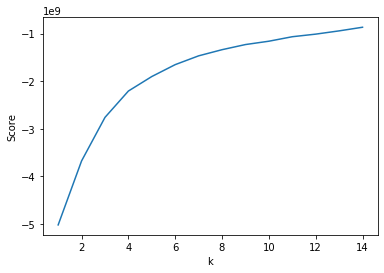

In [15]:
# finding best k 
Nc = range(1,15)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]

# ploting the curve
plt.plot(Nc,score)
plt.xlabel('k')
plt.ylabel('Score')
plt.show()

In [16]:
# select k = 4
k = 5
demo_clusters = df_demo.drop('Area', 1)
kmeans = KMeans (n_clusters = k, random_state = 0).fit(data)
kmeans.labels_

array([3, 3, 0, 4, 1, 0, 1, 1, 1, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 1, 1, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 4, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0,
       3, 0, 4, 4, 4, 0, 0, 2, 0, 0, 3, 4, 0, 0, 0, 2, 4, 4, 0, 1, 1, 4,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0,
       4, 1, 3, 4, 1, 0, 4, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 3, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [17]:
df_demo_sorted.insert(0,'Cluster', kmeans.labels_)
df_demo_sorted.head()

,Cluster,Area,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
0,3,Agincourt North,Chinese,Sri Lankan,East Indian
1,3,Agincourt South-Malvern West,Chinese,East Indian,Filipino
2,0,Alderwood,English,Canadian,Irish
3,4,Annex,English,Irish,Scottish
4,1,Banbury-Don Mills,Chinese,English,Irish


In [18]:
df_tor_merged = df_neig
df_tor_merged = df_tor_merged.join (df_demo_sorted.set_index(['Area']), on=['Area'])
df_tor_merged

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian
1,128,Agincourt South-Malvern West,43.78736,-79.26935,3,Chinese,East Indian,Filipino
2,20,Alderwood,43.60496,-79.54116,0,English,Canadian,Irish
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish
...,...,...,...,...,...,...,...,...
135,94,Wychwood,43.67734,-79.42497,0,English,Irish,Scottish
136,100,Yonge-Eglinton,43.70572,-79.40322,0,English,Canadian,Irish
137,97,Yonge-St.Clair,43.68883,-79.39887,0,English,Scottish,Irish
138,27,York University Heights,43.75997,-79.48520,0,Italian,Filipino,East Indian


In [19]:
# Mapping results

# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, area, cluster in zip(df_tor_merged['Latitude'], df_tor_merged['Longitude'], df_tor_merged['Area'], df_tor_merged['Cluster']):
    label = folium.Popup(str(area) + ' , Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id="item3"> </a>
### 3. Exploring Neighbourhoods
In this stage, we'll explore ethnicity groups per each cluster found by the algorithm to determine clusters with most chinese population

In [20]:
# Exploring Cluster 0
df_tor_merged[df_tor_merged['Cluster'] == 0].head(20)
# this cluster contains mostly europeans

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
2,20,Alderwood,43.604960,-79.541160,0,English,Canadian,Irish
5,34,Bathurst Manor,43.763780,-79.454770,0,Filipino,Russian,Italian
9,39,Bedford Park-Nortown,43.730660,-79.424500,0,Canadian,Polish,English
10,112,Beechborough-Greenbrook,43.693110,-79.478310,0,Portuguese,Jamaican,Italian
13,24,Black Creek,43.766360,-79.521500,0,Vietnamese,Jamaican,Canadian
14,69,Blake-Jones,43.675220,-79.337620,0,English,Canadian,Irish
15,108,Briar Hill-Belgravia,43.698520,-79.451250,0,Filipino,Italian,Portuguese
16,41,Bridle Path-Sunnybrook-York Mills,43.727320,-79.380870,0,English,Scottish,Canadian
17,57,Broadview North,43.689370,-79.354290,0,English,Irish,Scottish
18,30,Brookhaven-Amesbury,43.700310,-79.484650,0,Italian,Portuguese,Jamaican


In [21]:
# Exploring Cluster 1
df_tor_merged[df_tor_merged['Cluster'] == 1].head(20)

# this cluster contains mostly chinese

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino
30,47,Don Valley Village,43.78558,-79.34986,1,Chinese,Filipino,East Indian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English


In [22]:
# Exploring Cluster 2
df_tor_merged[df_tor_merged['Cluster'] == 2].head(20)

#This cluster contains mostly indians

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
73,132,Malvern,43.81023,-79.22038,2,East Indian,Sri Lankan,Filipino
81,2,Mount Olive-Silverstone-Jamestown,43.74721,-79.58826,2,East Indian,Iraqi,Jamaican
105,131,Rouge,43.80766,-79.17405,2,East Indian,Sri Lankan,Canadian
124,1,West Humber-Clairville,43.71456,-79.59261,2,East Indian,Jamaican,Canadian
132,137,Woburn,43.76748,-79.22829,2,East Indian,Canadian,Sri Lankan


In [23]:
# Exploring Cluster 3
df_tor_merged[df_tor_merged['Cluster'] == 3].head(20)

# Chinese again

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
0,129,Agincourt North,43.80930,-79.26707,3,Chinese,Sri Lankan,East Indian
1,128,Agincourt South-Malvern West,43.78736,-79.26935,3,Chinese,East Indian,Filipino
66,117,L'Amoreaux,43.79730,-79.31222,3,Chinese,East Indian,Canadian
76,130,Milliken,43.82325,-79.27729,3,Chinese,Sri Lankan,East Indian
112,116,Steeles,43.81231,-79.32154,3,Chinese,East Indian,Canadian
129,51,Willowdale East,43.77249,-79.40041,3,Chinese,Iranian,Korean


In [24]:
# Exploring Cluster 4
df_tor_merged[df_tor_merged['Cluster'] == 4].head(20)

# europeans again

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin
3,95,Annex,43.66936,-79.40280,4,English,Irish,Scottish
12,122,Birchcliffe-Cliffside,43.69472,-79.26460,4,English,Irish,Canadian
23,75,Church-Yonge Corridor,43.66024,-79.37868,4,English,Irish,Scottish
32,93,Dovercourt-Wallace Emerson-Junction,43.66604,-79.43687,4,Portuguese,English,Canadian
35,62,East End-Danforth,43.68420,-79.29887,4,English,Irish,Scottish
49,88,High Park North,43.65769,-79.46449,4,English,Irish,Scottish
50,87,High Park-Swansea,43.64704,-79.47114,4,English,Irish,Scottish
58,14,Islington-City Centre West,43.63608,-79.54296,4,English,Canadian,Italian
68,105,Lawrence Park North,43.72830,-79.40642,4,English,Scottish,Canadian
69,103,Lawrence Park South,43.71852,-79.40576,4,English,Scottish,Canadian


<a id="item4"> </a>
### 4. Finding the Best Spot
In this stage we will use FoursquareAPI to determine locations of chinese restaurants in clusters with most chinese population, cluster 1 & 3. then we will select areas within these clusters with the lowest number of chinese restaurants as a candidate spots for our new restaurants

In [25]:
# Foursquare API Credentials
CLIENT_ID = '21JSEKSJLXENFSY1KYTQG2NHZCZ1I0V2SNAK4J5KZXIGEDJQ'
CLIENT_SECRET = 'ETDDNV0MUHMQBUPDIXSC0VSWHLHGDPQVYETZQSO3JRP1CEY5'
VERSION = '20200606' # Foursquare API version

# search radius and results limit
radius = 1000
limit = 1000

In [26]:

def searchVenues(neigh, lat, lng):
    
    venues=[]
    for neigh, lat, lng in zip(neigh, lat, lng):

        # create the API request URL to explore the neighbourhood using FoursquareAPI
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue : name, latitude, longitude, and the categories' names
        venues.append([(
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # add the venues in the dataframe
    nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
    nearby_venues.columns = [
                        'Neighbourhood Number',
                        'Area Latitude', 
                        'Area Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category'
    ]
    
    return(nearby_venues)

In [27]:
# Cluster 1 & 3 has most chinese residence as demonstrated before
tor_chinese = df_tor_merged[(df_tor_merged['Cluster'] == 1) | (df_tor_merged['Cluster'] == 3)]

# get venues for areas in cluster 1 & 3
chinese_rest_venues = searchVenues(  
                                    tor_chinese['Neighbourhood Number'],
                                    tor_chinese['Latitude'],
                                    tor_chinese['Longitude']
                                  )
# retrieve chinese resturan venues
chinese_rest_venues[(chinese_rest_venues['Venue Category'] == "Chinese Restaurant")].head()

,Neighbourhood Number,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,129,43.80930,-79.26707,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
22,129,43.80930,-79.26707,Kin Kin Bubble Tea Co,43.807852,-79.270296,Chinese Restaurant
32,128,43.78736,-79.26935,Congee Me 小米粥鋪,43.787392,-79.268387,Chinese Restaurant
33,128,43.78736,-79.26935,Asian Legend 味香村,43.788068,-79.266768,Chinese Restaurant
42,128,43.78736,-79.26935,Beef Noodle Restaurant 老李牛肉麵,43.785937,-79.276031,Chinese Restaurant


In [28]:
chinese_rest_count = chinese_rest_venues.groupby(['Neighbourhood Number','Area Latitude','Area Longitude']).count().reset_index()

# drop useless columns
chinese_rest_count = chinese_rest_count.drop(chinese_rest_count.columns[[1,2,3,4,5]], axis=1)
chinese_rest_count.columns = ['Neighbourhood Number','Count']

# merge counts with tor_chinese dataframe
tor_chinese = tor_chinese.join(chinese_rest_count.set_index(['Neighbourhood Number']), on = ['Neighbourhood Number'])
tor_chinese = tor_chinese.sort_values(by='Count')
tor_chinese.head(20)

,Neighbourhood Number,Area,Latitude,Longitude,Cluster,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,Count
111,40,St.Andrew-Windfields,43.75720,-79.38188,1,Chinese,English,Canadian,5
130,37,Willowdale West,43.77134,-79.42802,1,Chinese,Korean,Iranian,6
98,46,Pleasant View,43.78812,-79.33453,1,Chinese,Greek,Italian,13
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,14
86,36,Newtonbrook West,43.78818,-79.43173,1,Filipino,Chinese,Russian,16
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,17
76,130,Milliken,43.82325,-79.27729,3,Chinese,Sri Lankan,East Indian,17
112,116,Steeles,43.81231,-79.32154,3,Chinese,East Indian,Canadian,21
85,50,Newtonbrook East,43.79304,-79.40695,1,Chinese,Iranian,Korean,21
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,23


In [29]:
# select top 10
tor_chinese_top = tor_chinese.head(5)

# create map of Toronto using latitude and longitude values
spots_chinese = folium.Map([lat, lng], zoom_start=11)

# add markers to map
for lat, lng, neigh, Area in zip(tor_chinese_top['Latitude'], tor_chinese_top['Longitude'], tor_chinese_top['Neighbourhood Number'], tor_chinese_top['Area']):
    label = '{} - {}'.format( neigh, Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(spots_chinese) 
    
spots_chinese

Candidate areas are shown in map in blue